In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import cv2

import numpy as np

import csv

import matplotlib.pyplot as plt

In [ ]:
#Step0: Load csv driving record files#
#Note: csv file must be at local directory
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.listdir()
os.chdir('/content/gdrive/MyDrive/APS360Group2') #Your local copy dir#

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# PART 1: DATA

In [ ]:
# Step1: Read from the log file
samples = []
with open('driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # Skip the first row
    for line in reader:
        samples.append(line)

此block为测试代码

In [ ]:
#Dvide into two sets: 
train_len = int(0.8*len(samples))
valid_len = int((len(samples) - train_len)/2)
test_len = valid_len
train_samples, validation_samples, test_samples = data.random_split(samples, lengths=[train_len, valid_len, test_len])

In [ ]:
print('train samples size: ', len(train_samples))
print('valid samples size: ', len(validation_samples))
print('test samples size: ', len(test_samples))

train samples size:  6428
valid samples size:  804
test samples size:  804


In [ ]:
def augment(imgName, angle):
  '''
  Input original CSV file image directory, return new Gdrive directory, 
  the numpy array represented image, and correlated data

  Input: 
  - sample list organized from CSV driving record
  - angle: desired turn angle correlated

  Output: 
  - name: new image directory under Gdrive; 
  - current_image: cropped image data array; 
  - angle: desired turn angle correlated; 

  A number of randomly selected images would be flipped. If this is the case, 
  their correlated turn angle would be flipped as well. If this is not the case,
  the angle would be unchanged. 
  '''

  name = '/content/gdrive/MyDrive/APS360Group2/IMG/' + imgName.split('/')[-1]
  current_image = cv2.imread(name)
  current_image = current_image[65:-25, :, :]

  if np.random.rand() < 0.5:
    current_image = cv2.flip(current_image, 1) 
    angle = angle * -1.0  
  #print(name)
  return name, current_image, angle


In [ ]:
class Dataset(data.Dataset):
  '''
  A torch dataset class
  '''
  def __init__(self, samples, transform=None):
    '''
    sample: sample list organized from csv file
    transform: Image transform requirements
    '''
    self.samples = samples
    self.transform = transform

  def __getitem__(self, index):
    '''
    Overwritting default data fetching subclass __getitem__

    Get an instance of driving records, and grouped into three tuples in 
    regards of center, left, and right camera footage; 

    The camera footage (images) will be represented as its numpy array form. 
    Its correlated key (turn degree in this case) will be a float. 

    input: 
    - index: index of given instance in the sample
    output: 
    - three tuples in the forms of (image, correlated data)
    '''
    #===========Index the wanted instance================
    batch_samples = self.samples[index]
    #===========Get the steering angle===================
    steering_angle = stra = float(batch_samples[3])
    #===========Get image address========================
    # This is done via augment function. 
    # For left and right camera footage: An steering angle offset is added to
    # represent the difference of angle between cameras. 
    center_img, steering_angle_center = augment(batch_samples[0], stra)[1:]
    left_img, steering_angle_left = augment(batch_samples[1], stra + 0.4)[1:]
    right_img, steering_angle_right = augment(batch_samples[2], stra - 0.4)[1:]
    #============Image tansformation=====================
    # If transform para are ordered, image will be transformed accordintly
    if self.transform != None: 
      center_img = self.transform(center_img)
      left_img = self.transform(left_img)
      right_img = self.transform(right_img)
    return (center_img, steering_angle_center), (left_img, steering_angle_left), (right_img, steering_angle_right)
    
  def __len__(self):
    '''
    Return amount of total samples
    '''
    return len(self.samples)
                                    

In [ ]:
def make_weights_for_balanced_classes(dataset, nclasses=5):                        
    count = [0] * nclasses
    cls  = []
    cls_no = [] 

    print('number of classes established', count)  

    for record_instance, (centers, lefts, rights) in enumerate(dataset): 
        datas = [centers, lefts, rights]
        item = datas[0]      # item: (center_img, steering_angle_center)                                            
        if item[1] < -0.4 and item[1] >= -1:
          count[0] += 1
          cls_no.append(0)
          cls.append('right big')
        elif item[1] >= -0.4 and item[1] < 0:
          count[1] += 1
          cls_no.append(1)
          cls.append('right small')
        elif item[1] == 0:
          count[2] += 1
          cls_no.append(2)
          cls.append('straight')
        elif item[1] > 0 and item[1] <= 0.4:
          count[3] += 1
          cls_no.append(3)
          cls.append('left small')
        elif item[1] > 0.4 and item[1] <= 1:
          count[4] += 1 
          cls_no.append(4)
          cls.append('left big')
        # Debug: 
        print('item class:', cls[-1], 'item angle:', item[1])
        print('count:', record_instance)

    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))        

    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
        weight = [0] * len(dataset) 

    for record_instance, (centers, lefts, rights) in enumerate(dataset):
        datas = [centers, lefts, rights]
        item = datas[0]      # item: (center_img, steering_angle_center)                                     
        weight[record_instance] = weight_per_class[cls_no[record_instance]]

    print('weights(str): rightb, rights, straight, lefts, leftb') 
    print('weights(flt):', weight_per_class)
    print('number of weights assigned:', len(weight))

    return weight                           

In [ ]:

# Define transformation parameter: 
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])
training_set = Dataset(train_samples, transformations)
t_weights = make_weights_for_balanced_classes(training_set)
t_weights = torch.DoubleTensor(t_weights)
t_samp = torch.utils.data.sampler.WeightedRandomSampler(t_weights, len(t_weights))


validation_set = Dataset(validation_samples, transformations)
v_weights = make_weights_for_balanced_classes(validation_set)
v_weights = torch.DoubleTensor(v_weights)
v_samp = torch.utils.data.sampler.WeightedRandomSampler(v_weights, len(v_weights))


# PART 2: Designed MODEL


In [ ]:
### Create NN Network based on Nividia structure: ###

class NetworkLight(nn.Module):

    def __init__(self):
        super(NetworkLight, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 3, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 48, 3, stride=2),
            nn.MaxPool2d(4, stride=4),
            nn.Dropout(p=0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=48*4*19, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        

    def forward(self, input):
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        #print('iteration complete, output shape: ', output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

# PART 3: TRAIN

In [ ]:

## GPU acceleration: ##
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device is: ', device)

def toDevice(datas, device):
  
  imgs, angles = datas
  return imgs.float().to(device), angles.float().to(device)

  

device is:  cpu


In [ ]:
## Train: ##

def train_rnn(model, training_generator, validation_generator, 
              num_epochs=5, learning_rate=1e-4, batch_size = 32,
          debug=True, plot_loss=True, plot_accu=True ):
  
  max_epochs = num_epochs #ORIGINAL 22
  ## Optimizer and Criterion: ##
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.MSELoss()

  ###########Data storing for plotting###########
  #******************************************
  iter_train = []
  iter_vali = []
  iter = []
  m = 0
  n = 0
  
  train_loss = []
  valid_loss = []
  train_accu = []
  valid_accu = []

  for epoch in range(max_epochs):
    model.to(device)
    #model.train()

    ##################Training#####################
    for record_instance, (centers, lefts, rights) in enumerate(training_generator):
      train_loss_iter = 0
      # Number of instance per batch = total set / (epochs * 3)
      # Considering passing through one instance as an interation
      # GPU Acce: 
      centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
      # Split data into three parts: 
      datas = [centers, lefts, rights]  
      # Training:    
      for data in datas:
        imgs, angles = data
        imgs = imgs.float()
        angles = angles.float()
        # Forward Pass: 
        outputs = model(imgs)
        train_loss_i = criterion(outputs, angles.unsqueeze(1))
        train_loss_iter += float(train_loss_i.item())
        # Backward Pass: 
        train_loss_i.backward()
        optimizer.step()
        optimizer.zero_grad()
      
      #********************************************
      train_loss_epoch = train_loss_iter/(batch_size)
      train_loss.append(train_loss_epoch)
      m += 1
      iter_train.append(m)
      
    print("Epoch", epoch+1, " Training process is done!")

    ##################Validation###################
    for record_instance, (centers, lefts, rights) in enumerate(validation_generator):
      valid_loss_iter = 0
      # GPU Acce: 
      centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
      # Split data into three parts: 
      datas = [centers, lefts, rights] 
      # Validation: 
      for data in datas: 
        imgs, angles = data
        imgs = imgs.float()
        angles = angles.float()
        outputs = model(imgs)
        valid_loss_i = criterion(outputs, angles.unsqueeze(1))
        valid_loss_iter += float(valid_loss_i.item())
      #************************************
      valid_loss_epoch = valid_loss_iter/(batch_size)
      valid_loss.append(valid_loss_epoch)
      n+=1
      iter_vali.append(n*8)
    print("Epoch", epoch+1, "Validation process is done!")


    ###############Epoch_Result####################
    '''
    train_accu.append(get_accuracy(model, training_generator)) 
    valid_accu.append(get_accuracy(model, validation_generator))
    '''
    iter.append(epoch+1)

    ###############Debug info######################**************************
    if debug == True: 
      print('Training loss: ', str(train_loss[-1]))
      print('Validation loss: ', str(valid_loss[-1]))    
      '''
      print('Training accuracy: ', str(train_accu[-1]))
      print('Validation accuracy: ', str(valid_accu[-1]))
      '''
      print('---------------------------------')

  ###############Graphing##########################
  if plot_loss == True:
    plt.title("Loss")
    plt.plot(iter_train, train_loss, label="Train loss")
    plt.plot(iter_vali, valid_loss, label="Valid loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

  plt.title("Training Curve - Loss")
  plt.plot(iter_train, train_loss, label="Train loss")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  plt.title("Validation Curve - Loss")
  plt.plot(iter_vali, valid_loss, label="Vali loss")
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  
  return True

In [ ]:
## Get Accuacy ##
def accuracy_testing(model, data_loader): 
  cls_no = [] #Not used
  cls = [] #Class of objects
  output_list = [] 
  err_0 = []
  err_1 = []
  err_2 = []
  err_3 = []
  err_4 = []
  err_list = []
  count = [0,0,0,0,0]
  for record_instance, (centers, lefts, rights) in enumerate(data_loader): 
    datas = [centers, lefts, rights] 
    for data in datas: 
      imgs, angles = data
      imgs = imgs.float()
      angles = angles.float()

      #########################Test the Model####################################  
      outputs = model(imgs)
      output_list.append(outputs.item())
      err = abs(outputs.item() - angles)
      err = err.item()
      err_list.append(err)
    #########################Determine the Turning Class########################
      if angles < -0.4 and angles >= -1:
        count[0] += 1
        cls_no.append(0)
        cls.append('right big')
        err_0.append(err)
      elif angles >= -0.4 and angles < 0:
        count[1] += 1
        cls_no.append(1)
        cls.append('right small')
        err_1.append(err)
      elif angles == 0:
        count[2] += 1
        cls_no.append(2)
        cls.append('straight')
        err_2.append(err)
      elif angles > 0 and angles <= 0.4:
        count[3] += 1
        cls_no.append(3)
        cls.append('left small')
        err_3.append(err)
      elif angles > 0.4 and angles <= 1:
        count[4] += 1 
        cls_no.append(4)
        cls.append('left big')
        err_4.append(err)
      
      angles = angles.item()
     ############################Record#########################################
      print('======================================')
      print('instance: %s, turn: %s, angles: %s, outputs: %s, error: %s '
    %(record_instance, cls[-1], angles, outputs.item(), err_list[-1]))
  
  ##########################Graphing#########################################
  avg_err = []
  avg_err.append((sum(err_4)/count[4])*45)
  avg_err.append((sum(err_3)/count[3])*45)
  avg_err.append((sum(err_2)/count[2])*45)
  avg_err.append((sum(err_1)/count[1])*45)
  avg_err.append((sum(err_0)/count[0])*45)

  fig, ax = plt.subplots()
  plt.bar(np.arange(5), avg_err, width=0.35)

  ax.set_xticks(np.arange(5))
  ax.set_xticklabels(('Left Sharp', 'Left', 'Straight', 
                      'Right ', 'Right Sharp'))
  ax.set_ylabel('error in degrees')
  ax.set_title('Difference between model steering commands against ideal turn angles')
  ax.legend()

  
  print("avg error for class1:", sum(err_0)/count[0], 
        "class2:", sum(err_1)/count[1], 
        "class3:", sum(err_2)/count[2], 
        "class4:", sum(err_3)/count[3], 
        "calss5:", sum(err_4)/count[4])

  return err

Epoch 1  Training process is done!
Epoch 1 Validation process is done!
Training loss:  0.00973671954125166
Validation loss:  0.005529708927497268
---------------------------------
Epoch 2  Training process is done!
Epoch 2 Validation process is done!
Training loss:  0.006462217075750232
Validation loss:  0.00529746466781944
---------------------------------
Epoch 3  Training process is done!
Epoch 3 Validation process is done!
Training loss:  0.00531303696334362
Validation loss:  0.01212758058682084
---------------------------------
Epoch 4  Training process is done!
Epoch 4 Validation process is done!
Training loss:  0.00428284949157387
Validation loss:  0.0036410350585356355
---------------------------------
Epoch 5  Training process is done!
Epoch 5 Validation process is done!
Training loss:  0.00460377405397594
Validation loss:  0.0038315840356517583
---------------------------------
Epoch 6  Training process is done!
Epoch 6 Validation process is done!
Training loss:  0.0060721205

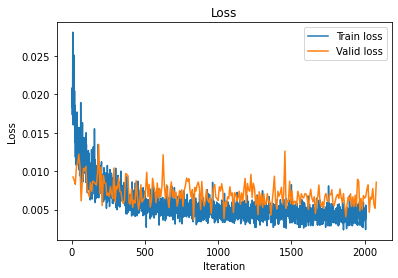

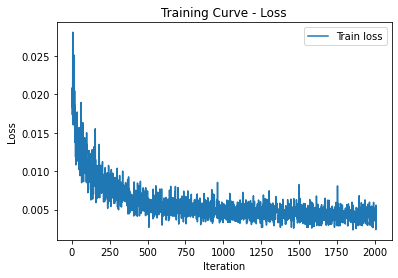

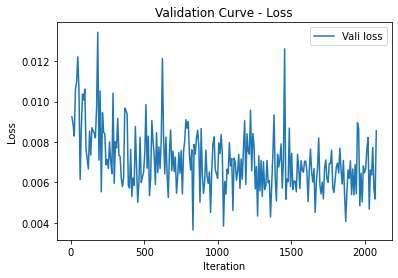

True

In [ ]:
# Define dataloader parameter: 
params = {'batch_size': 32     ,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model1 = NetworkLight()
train_rnn(model1, training_generator, validation_generator, 
              num_epochs=10, learning_rate=0.0001, batch_size = 32,
          debug=True, plot_loss=True, plot_accu=True )

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 2}
# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)
accuracy_testing(model1, data_loader = training_generator)
accuracy_testing(model1, data_loader = validation_generator)

Epoch 1  Training process is done!
Epoch 1 Validation process is done!
Training loss:  0.004402734339237213
Validation loss:  0.004563571244943887
---------------------------------
Epoch 2  Training process is done!
Epoch 2 Validation process is done!
Training loss:  0.0027442159480415285
Validation loss:  0.0035875290050171316
---------------------------------
Epoch 3  Training process is done!
Epoch 3 Validation process is done!
Training loss:  0.0025111951981671154
Validation loss:  0.004169864812865853
---------------------------------
Epoch 4  Training process is done!
Epoch 4 Validation process is done!
Training loss:  0.0031080616754479706
Validation loss:  0.003311550128273666
---------------------------------
Epoch 5  Training process is done!
Epoch 5 Validation process is done!
Training loss:  0.002451385895255953
Validation loss:  0.004652812727726996
---------------------------------
Epoch 6  Training process is done!
Epoch 6 Validation process is done!
Training loss:  0.00

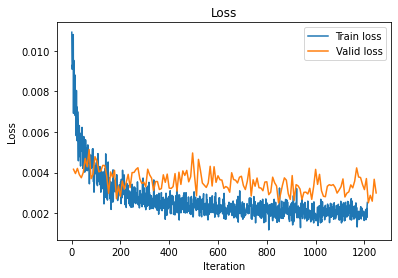

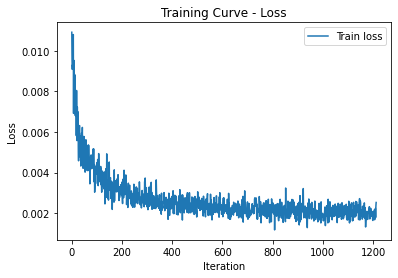

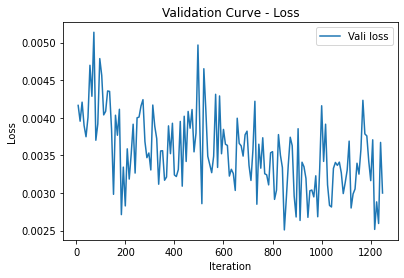

True

In [ ]:
# Define dataloader parameter: 
params = {'batch_size': 64     ,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model2 = NetworkLight()
train_rnn(model2, training_generator, validation_generator, 
              num_epochs=12, learning_rate=0.0002, batch_size = 64,
          debug=True, plot_loss=True, plot_accu=True )

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 2}
# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)
accuracy_testing(model2, data_loader = training_generator)
accuracy_testing(model2, data_loader = validation_generator)

Epoch 1  Training process is done!
Epoch 1 Validation process is done!
Training loss:  0.0023240389418788254
Validation loss:  0.0022051171108614653
---------------------------------
Epoch 2  Training process is done!
Epoch 2 Validation process is done!
Training loss:  0.0016337003035005182
Validation loss:  0.001676288724411279
---------------------------------
Epoch 3  Training process is done!
Epoch 3 Validation process is done!
Training loss:  0.001324922137428075
Validation loss:  0.0017046631255652755
---------------------------------
Epoch 4  Training process is done!
Epoch 4 Validation process is done!
Training loss:  0.0012240723299328238
Validation loss:  0.0018696647020988166
---------------------------------
Epoch 5  Training process is done!
Epoch 5 Validation process is done!
Training loss:  0.0008870625897543505
Validation loss:  0.0016451260598842055
---------------------------------
Epoch 6  Training process is done!
Epoch 6 Validation process is done!
Training loss:  

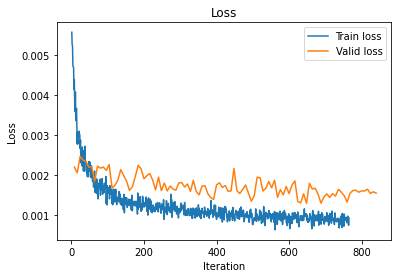

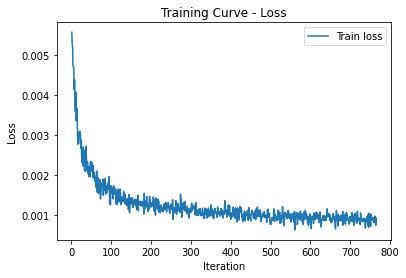

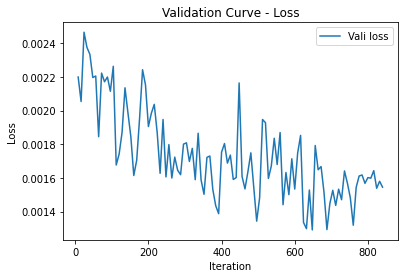

True

In [ ]:
 # Define dataloader parameter: 
params = {'batch_size': 128     ,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model3 = NetworkLight()
train_rnn(model3, training_generator, validation_generator, 
              num_epochs=15, learning_rate=0.0005, batch_size = 128,
          debug=True, plot_loss=True, plot_accu=True )

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 2}
# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
accuracy_testing(model3, data_loader = training_generator)

In [ ]:
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)
accuracy_testing(model3, data_loader = validation_generator)

Epoch 1  Training process is done!
Epoch 1 Validation process is done!
Training loss:  0.0010906739044003189
Validation loss:  0.0013778723950963467
---------------------------------
Epoch 2  Training process is done!
Epoch 2 Validation process is done!
Training loss:  0.0008630511874798685
Validation loss:  0.0010903405491262674
---------------------------------
Epoch 3  Training process is done!
Epoch 3 Validation process is done!
Training loss:  0.0010067011753562838
Validation loss:  0.0007971904706209898
---------------------------------
Epoch 4  Training process is done!
Epoch 4 Validation process is done!
Training loss:  0.00047073880705283955
Validation loss:  0.001127414929214865
---------------------------------
Epoch 5  Training process is done!
Epoch 5 Validation process is done!
Training loss:  0.000512545884703286
Validation loss:  0.0011379692296031862
---------------------------------
Epoch 6  Training process is done!
Epoch 6 Validation process is done!
Training loss: 

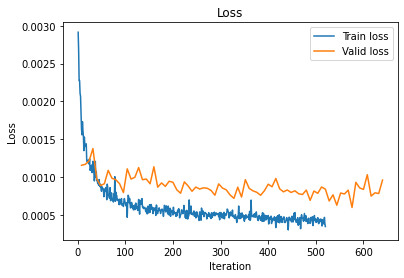

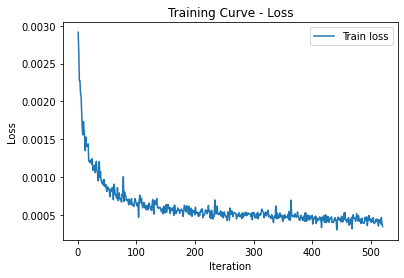

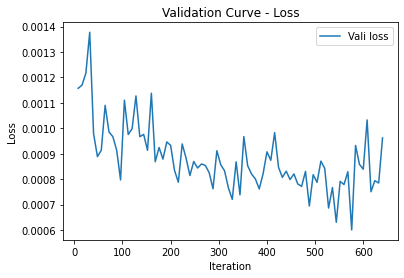

True

In [ ]:
 # Define dataloader parameter: 
params = {'batch_size': 256,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model4 = NetworkLight()
train_rnn(model4, training_generator, validation_generator, 
              num_epochs=20, learning_rate=0.001, batch_size = 256,
          debug=True, plot_loss=True, plot_accu=True )

In [ ]:
params = {'batch_size': 1,
          'shuffle': False,
          'num_workers': 1}
# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
accuracy_testing(model4, data_loader = training_generator)


In [ ]:
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)
accuracy_testing(model4, data_loader = validation_generator)

#Part 4: Testing

In [ ]:
test_set = Dataset(test_samples, transformations)
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 1}
test_generator = DataLoader(test_set, **params)

In [ ]:
accuracy_testing(model3, data_loader = test_generator)

# Part 5: Model Saving

In [ ]:
state = {
        'model': model.module if device == 'cuda' else model,
        }

torch.save(state, 'model.h5')

# Part 6: Nvidia Model
For reference

In [ ]:
class NetworkDense(nn.Module):

    def __init__(self):
        super(NetworkDense, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.25)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 2 * 33, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        
    def forward(self, input):  
        input = input.view(input.size(0), 3, 70, 320)
        output = self.conv_layers(input)
        
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

In [ ]:
# Define dataloader parameter: 
params = {'batch_size': 32,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model_nvidia = NetworkDense()
train_rnn(model_nvidia, training_generator, validation_generator, 
              num_epochs=15, learning_rate=0.0001, batch_size = 32,
          debug=True, plot_loss=True, plot_accu=True )

In [ ]:
params = {'batch_size': 128,
          'shuffle': False,
          'num_workers': 2}

# Construct dataset class -> construct dataloader based on dataset
training_generator = DataLoader(training_set, **params, sampler=t_samp)
validation_generator = DataLoader(validation_set, **params, sampler=v_samp)

model_nvidia_128 = NetworkDense()
train_rnn(model_nvidia_128, training_generator, validation_generator, 
              num_epochs=15, learning_rate=0.0005, batch_size = 128,
          debug=True, plot_loss=True, plot_accu=True )